
# ACH vs Control — Comparative Analysis Notebook

This notebook performs a **side-by-side comparison** of Ach stimulation datasets vs **Control** datasets across:
- Event composition and sizes (Global, Sequential, Individual)
- Per-peak metrics (duration, prominence) within and across events
- Global event dynamics (time to 50%, normalized rate, % cells involved)
- Sequential event communications (distance, speed, pair statistics)
- Cell-level participation patterns (individual vs sequential vs global)
- **Cell-density** relationships for each condition
- Robust non-parametric tests and correlations with bootstrap confidence intervals

> The plotting API is built on the project's visualizer utilities (violin, histogram, pie, regression, etc.) you shared. fileciteturn0file0


In [1]:

# %% [Usage]
# To run end-to-end, execute all cells top-to-bottom.
# Dependencies: project package `calcium_activity_characterization` must be importable.

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns

# Project path setup
project_root = Path.cwd().parent
source_path = project_root / "src"
if source_path.exists() and str(source_path) not in sys.path:
    sys.path.insert(0, str(source_path))

# Style
sns.set_style("whitegrid", rc={"font.family": "sans-serif", "font.sans-serif": ["Arial"]})

# Logging
from calcium_activity_characterization.logger import logger

# Project utilities
from calcium_activity_characterization.io.csv_loader import load_dataset
from calcium_activity_characterization.analysis.statistics import (
    analyze_peak_intervals,
    build_neighbor_pair_stats,
    kw_dunn,
    brunner_pairs,
    wilcoxon_pairs,
    corr_nonparametric,
)

# Visualizers (from your helper file)
from calcium_activity_characterization.analysis.visualizers import (
    plot_violin,
    plot_points_mean_std,
    visualize_image,
    plot_scatter_size_coded,
    plot_histogram,
    plot_histogram_by_group,
    plot_pie_chart,
    plot_bar,
    plot_xy_with_regression,
    plot_heatmap,
    plot_early_peakers_heatmap,
    plot_category_distribution_by_dataset,
)


In [2]:

# --- Configuration ---
# Root containing your CSVs
DATA_ROOT = Path("D:/Mateo/Results")

# Output directories for figures (tweak as needed)
FIG_ACH = Path("C:/Users/poseidon/OneDrive/Documents/01_ETHZ/Master_Degree/Spring_Semester_2025/Master_Thesis/Report/Figures/Chapter_4")
FIG_CTRL = Path("C:/Users/poseidon/OneDrive/Documents/01_ETHZ/Master_Degree/Spring_Semester_2025/Master_Thesis/Report/Figures/Chapter_3")
FIG_ACH.mkdir(parents=True, exist_ok=True)
FIG_CTRL.mkdir(parents=True, exist_ok=True)

# --- Load CSVs ---
experiments = load_dataset(path=str(DATA_ROOT), file_name="merged_experiments.csv") if (DATA_ROOT / "merged_experiments.csv").exists() else load_dataset(path=str(DATA_ROOT), file_name="experiments.csv")
peaks        = load_dataset(path=str(DATA_ROOT), file_name="merged_peaks.csv")
cells        = load_dataset(path=str(DATA_ROOT), file_name="merged_cells.csv")
events       = load_dataset(path=str(DATA_ROOT), file_name="merged_events.csv")
communications = load_dataset(path=str(DATA_ROOT), file_name="merged_communications.csv")

logger.info("Loaded tables: exp=%s peaks=%s cells=%s events=%s comm=%s",
            experiments.shape, peaks.shape, cells.shape, events.shape, communications.shape)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")


[2025-08-26 14:34:07] [INFO] calcium: Loaded tables: exp=(71, 9) peaks=(371621, 32) cells=(59342, 23) events=(38384, 35) comm=(97580, 21)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")


In [3]:
# --- Harmonize keys, compute density once, and propagate condition labels ---

# 0) Safety: required columns
required_cols = {"dataset", "concentration"}
for name, df in {
    "experiments": experiments, "peaks": peaks, "cells": cells,
    "events": events, "communications": communications
}.items():
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"{name} missing columns: {missing}")

# 1) Canonicalize dataset keys everywhere: "<dataset>_<concentration>"
for df in (experiments, peaks, cells, events, communications):
    df["dataset"] = df["dataset"].astype(str) + "_" + df["concentration"].astype(str)

# 2) Compute cell density (number of cells per canonical dataset) and map into all tables
cell_counts = cells.groupby("dataset")["Cell ID"].count()
for df in (experiments, events, cells, peaks, communications):
    df["Dataset cell density"] = df["dataset"].map(cell_counts)

# 3) Make sure peaks have an event label
peaks["In event"] = peaks["In event"].fillna("individual")

# --- Build cohort sets from experiments (using your filters) ---
ACH_FILTER = (
    (experiments["condition"] == "ACH - 1st run")
    & (experiments["time"] == "+2d")
    & (experiments["Dataset cell density"] > 900)
)
CTRL_FILTER = (
    (experiments["condition"] == "control - 1st run")
    & (experiments["Dataset cell density"] > 900)
)

ach_experiments = experiments.loc[ACH_FILTER].copy()
ctrl_experiments = experiments.loc[CTRL_FILTER].copy()

ds_ach  = set(ach_experiments["dataset"])
ds_ctrl = set(ctrl_experiments["dataset"])

# --- Create a de-duplicated (dataset -> condition_group) mapping ---
cond_key = experiments[["dataset"]].drop_duplicates()
cond_key["condition_group"] = np.where(
    cond_key["dataset"].isin(ds_ach), "ACH",
    np.where(cond_key["dataset"].isin(ds_ctrl), "Control", "Other")
)

# --- Attach condition_group to EVERY table via 1:m merge ---
def _attach_condition(df: pd.DataFrame) -> pd.DataFrame:
    # validate="m:1" guards against accidental many-to-many joins
    return df.merge(cond_key, on="dataset", how="left", validate="m:1")

experiments    = _attach_condition(experiments)
peaks          = _attach_condition(peaks)
cells          = _attach_condition(cells)
events         = _attach_condition(events)
communications = _attach_condition(communications)

# --- Sanity checks (optional but helpful) ---
for name, df in [("experiments", experiments), ("peaks", peaks), ("cells", cells),
                 ("events", events), ("communications", communications)]:
    assert "condition_group" in df.columns, f"{name} is missing condition_group"
    # Uncomment to inspect distribution:
    # print(name, df["condition_group"].value_counts(dropna=False).to_dict())

ach_peaks = peaks[peaks["condition_group"] == "ACH"]
ctrl_peaks = peaks[peaks["condition_group"] == "Control"]

ach_cells = cells[cells["condition_group"] == "ACH"]
ctrl_cells = cells[cells["condition_group"] == "Control"]

ach_events = events[events["condition_group"] == "ACH"]
ctrl_events = events[events["condition_group"] == "Control"]

ach_comms = communications[communications["condition_group"] == "ACH"]
ctrl_comms = communications[communications["condition_group"] == "Control"]

# Keep only ACH / Control rows, drop the 'Other'
valid_conditions = {"ACH", "Control"}

experiments    = experiments[experiments["condition_group"].isin(valid_conditions)].copy()
peaks          = peaks[peaks["condition_group"].isin(valid_conditions)].copy()
cells          = cells[cells["condition_group"].isin(valid_conditions)].copy()
events         = events[events["condition_group"].isin(valid_conditions)].copy()
communications = communications[communications["condition_group"].isin(valid_conditions)].copy()


## 1) Event counts per dataset and mix of event types

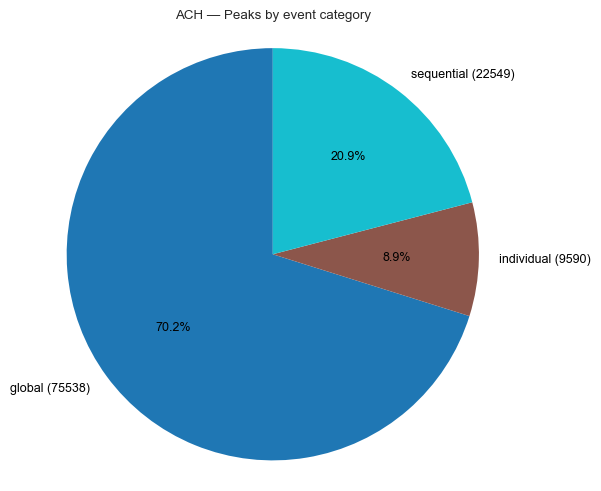

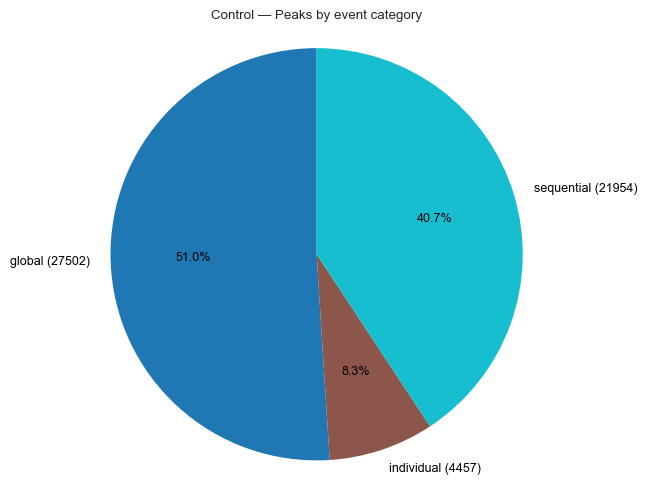

In [4]:

# Number of events per dataset
def _event_counts(ev: pd.DataFrame) -> pd.DataFrame:
    g = ev.groupby(["dataset", "Event type"]).size().reset_index(name="n_events")
    return g

ach_ev_counts = _event_counts(ach_events)
ctrl_ev_counts = _event_counts(ctrl_events)

# Pie on peak-level 'In event' (composition)
plot_pie_chart(ach_peaks, column="In event", title="ACH — Peaks by event category")
plot_pie_chart(ctrl_peaks, column="In event", title="Control — Peaks by event category")


## 2) Peak metrics — ACH vs Control

[2025-08-26 14:34:08] [INFO] calcium: plot_histogram_by_group: removed 65 outliers out of 161590 on 'Duration (s)' (lower=-172, upper=290)


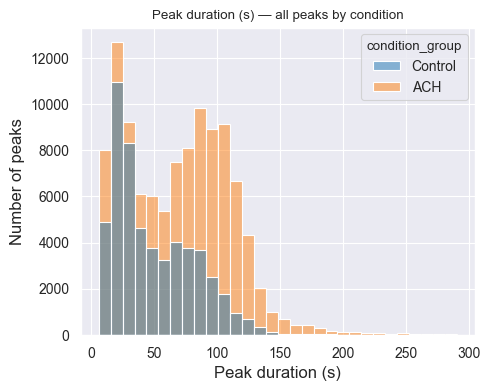

[2025-08-26 14:34:08] [INFO] calcium: plot_violin: removed 339 outliers out of 103040 on 'Duration (s)' (lower=-74, upper=237)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


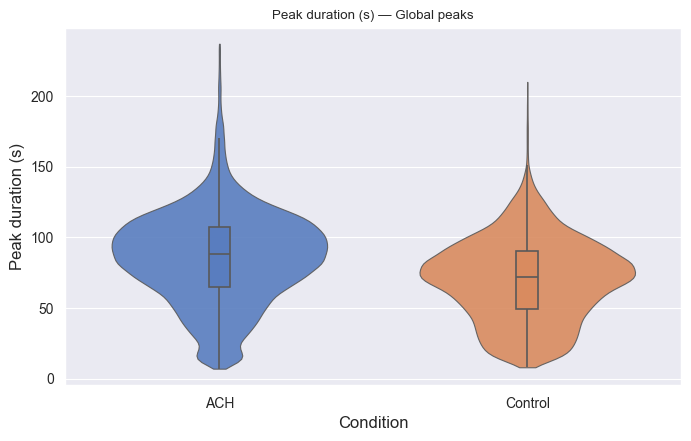

[2025-08-26 14:34:09] [INFO] calcium: plot_violin: removed 339 outliers out of 103040 on 'Duration (s)' (lower=-74, upper=237)
[2025-08-26 14:34:10] [INFO] calcium: plot_histogram_by_group: removed 47 outliers out of 161590 on 'Prominence (noise std units)' (lower=-535.2, upper=795.5)


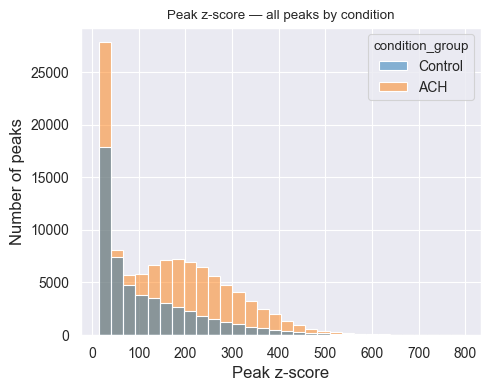

[2025-08-26 14:34:11] [INFO] calcium: plot_violin: removed 67 outliers out of 103040 on 'Prominence (noise std units)' (lower=-389, upper=732.2)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


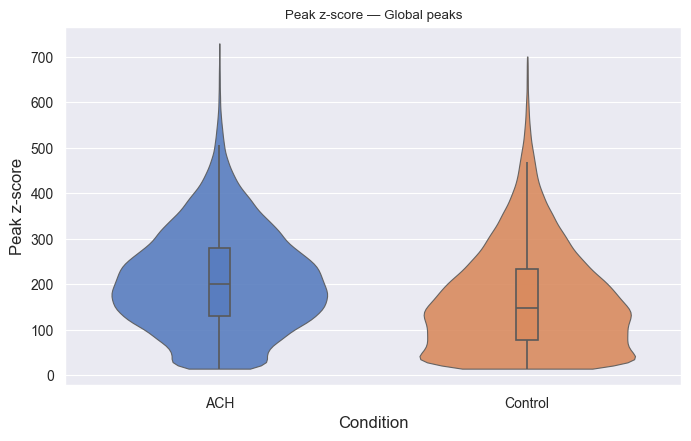

[2025-08-26 14:34:12] [INFO] calcium: plot_violin: removed 67 outliers out of 103040 on 'Prominence (noise std units)' (lower=-389, upper=732.2)


In [5]:

# Distributions by condition and event category
for val_col, xlabel in [("Duration (s)", "Peak duration (s)"),
                        ("Prominence (noise std units)", "Peak z-score")]:
    plot_histogram_by_group(
        df=peaks[peaks["In event"].isin(["global", "sequential", "individual"])],
        value_column=val_col,
        group_column="condition_group",
        title=f"{xlabel} — all peaks by condition",
        xlabel=xlabel,
        ylabel="Number of peaks",
        multiple="layer",
        palette="tab10",
        filter_outliers=True,
        outliers_bounds=(3,3),
        return_outliers=False
    )

    # Stratify by event category, show violin per condition
    for evcat in ["global"]:
        subset = peaks[peaks["In event"] == evcat].copy()
        if subset.empty:
            continue
        plot_violin(
            df=subset,
            x="condition_group",
            y=val_col,
            title=f"{xlabel} — {evcat.title()} peaks",
            xlabel="Condition",
            ylabel=xlabel,
            filter_outliers=True,
            outliers_bounds=(3,3),
            outliers_bygroup="condition_group",
            width=0.7,
            dodge=False
        )
        # Non-parametric comparison
        brunner_pairs(
            df=subset.assign(group=subset["condition_group"]),
            group_col="group",
            value_col=val_col,
            filter_outliers=True,
            outliers_bounds=(3,3),
            outliers_bygroup="group",
            n_boot_ci=1000,
            alpha=0.05,
            print_results=False,
            p_adjust_method="holm"
        )


## 3) Global events — size & dynamics

[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: N=65 for condition_group=ACH
[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: N=23 for condition_group=Control


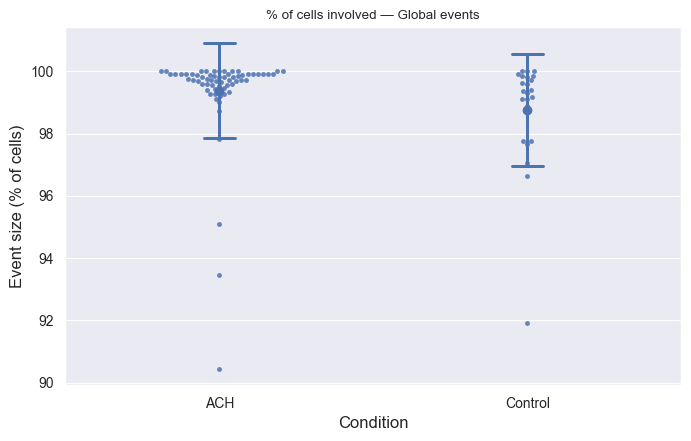

[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: removed 0/88 outliers on 'Time to 50% (s)' (lower=-18, upper=122)
[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: N=65 for condition_group=ACH
[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: N=23 for condition_group=Control


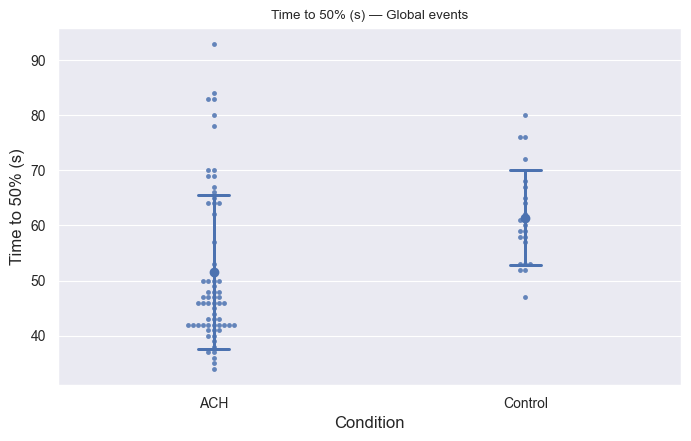

[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: removed 0/88 outliers on 'Normalized peak rate at 50% (% of peaks/s)' (lower=-0.45, upper=5.2)
[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: N=65 for condition_group=ACH
[2025-08-26 14:34:13] [INFO] calcium: plot_points_mean_std: N=23 for condition_group=Control


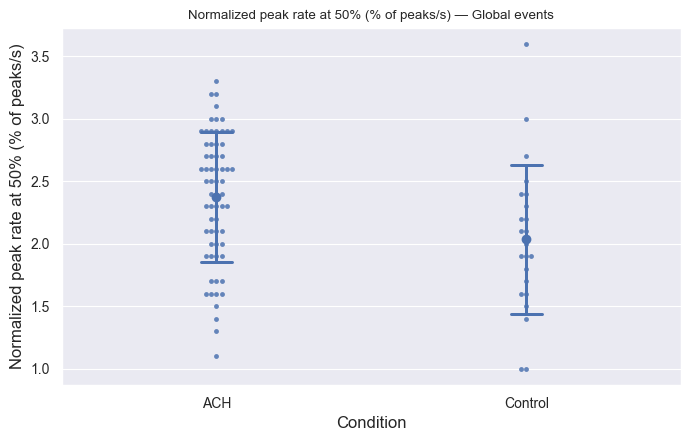

In [6]:

def _prep_global(ev: pd.DataFrame, cells_df: pd.DataFrame) -> pd.DataFrame:
    sub = ev[ev["Event type"] == "GlobalEvent"].copy()
    cell_counts = cells_df.groupby("dataset").size().rename("Total number of cells").reset_index()
    sub = sub.merge(cell_counts, on="dataset", how="left")
    sub["% of cells involved"] = 100 * sub["Number of cells involved"] / sub["Total number of cells"]
    return sub

ach_global = _prep_global(ach_events, ach_cells).assign(condition_group="ACH")
ctrl_global = _prep_global(ctrl_events, ctrl_cells).assign(condition_group="Control")
glob_all = pd.concat([ach_global, ctrl_global], ignore_index=True)

# Compare percent of cells involved
plot_points_mean_std(
    df=glob_all, x="condition_group", y="% of cells involved",
    title="% of cells involved — Global events", xlabel="Condition", ylabel="Event size (% of cells)",
    filter_outliers=False
)
wilcoxon_pairs(
    df=glob_all.assign(group=glob_all["condition_group"]),
    group_col="group", value_col="% of cells involved",
    n_boot_ci=1000, alpha=0.05, print_results=False, p_adjust_method="holm"
)

# Compare time-to-50% and normalized peak rate
for metric, label in [("Time to 50% (s)", "Time to 50% (s)"),
                      ("Normalized peak rate at 50% (% of peaks/s)", "Normalized peak rate at 50% (% of peaks/s)")]:

    plot_points_mean_std(
        df=glob_all, x="condition_group", y=metric,
        title=f"{label} — Global events", xlabel="Condition", ylabel=label,
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="condition_group"
    )
    wilcoxon_pairs(
        df=glob_all.assign(group=glob_all["condition_group"]),
        group_col="group", value_col=metric,
        n_boot_ci=1000, alpha=0.05, print_results=False, p_adjust_method="holm"
    )


## 4) Sequential events — peak metrics & communication speed

[2025-08-26 14:34:14] [INFO] calcium: plot_violin: removed 724 outliers out of 44503 on 'Duration (s)' (lower=-37, upper=89)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


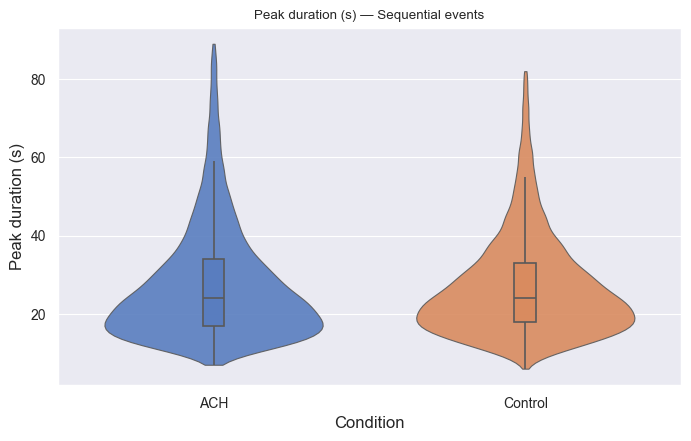

[2025-08-26 14:34:14] [INFO] calcium: plot_violin: removed 724 outliers out of 44503 on 'Duration (s)' (lower=-37, upper=89)
[2025-08-26 14:34:15] [INFO] calcium: plot_violin: removed 1628 outliers out of 44503 on 'Prominence (noise std units)' (lower=-134, upper=233.5)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


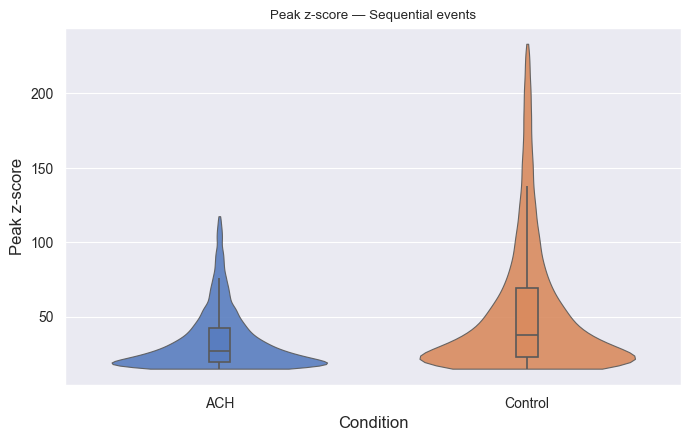

[2025-08-26 14:34:16] [INFO] calcium: plot_violin: removed 1628 outliers out of 44503 on 'Prominence (noise std units)' (lower=-134, upper=233.5)
[2025-08-26 14:34:16] [INFO] calcium: plot_violin: removed 518 outliers out of 33794 on 'Speed (um/s)' (lower=-14.225, upper=22.42)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


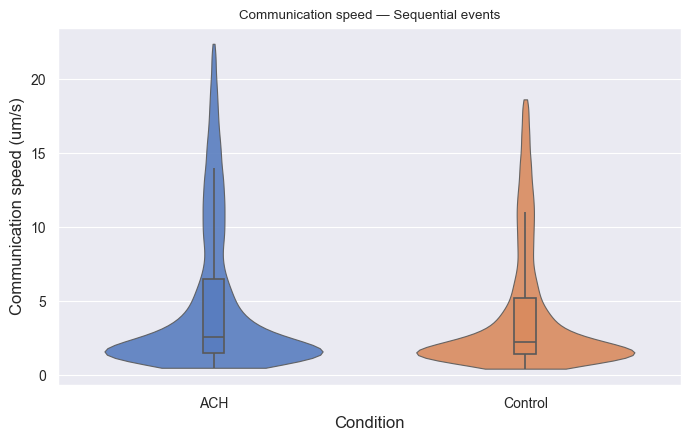

[2025-08-26 14:34:17] [INFO] calcium: plot_violin: removed 518 outliers out of 33794 on 'Speed (um/s)' (lower=-14.225, upper=22.42)


,group1,group2,n1,n2,median1,q1_1,q3_1,median2,q1_2,q3_2,bm_stat,bm_p,vd_A,cliffs_delta,median_diff,med_ci_low,med_ci_high,p_adj,reject
0,ACH,Control,16478,16798,2.57,1.48,6.49,2.24,1.4,5.24,-11.274987,1.973809e-29,0.53559,0.071181,0.33,0.26,0.39,1.973809e-29,True


In [7]:

# Map condition to events/peaks/comms
ds_to_cond = experiments.set_index("dataset")["condition_group"]
for df in (ach_events, ctrl_events, ach_peaks, ctrl_peaks, ach_comms, ctrl_comms):
    df["condition_group"] = df["dataset"].map(ds_to_cond)

# Sequential events: link peaks to SE only
def _map_event_type_to_peaks(peaks_df: pd.DataFrame, events_df: pd.DataFrame, event_kind: str) -> pd.DataFrame:
    mapping = events_df.loc[events_df["Event type"] == event_kind, ["Event ID", "dataset"]]
    return peaks_df.merge(mapping, on=["Event ID", "dataset"], how="inner", validate="m:1")

ach_se_peaks = _map_event_type_to_peaks(ach_peaks, ach_events, "SequentialEvent")
ctrl_se_peaks = _map_event_type_to_peaks(ctrl_peaks, ctrl_events, "SequentialEvent")
se_peaks_all = pd.concat([ach_se_peaks.assign(condition_group="ACH"),
                          ctrl_se_peaks.assign(condition_group="Control")], ignore_index=True)

# Peak metrics in SE
for metric, label in [("Duration (s)", "Peak duration (s)"),
                      ("Prominence (noise std units)", "Peak z-score")]:
    plot_violin(
        df=se_peaks_all,
        x="condition_group",
        y=metric,
        title=f"{label} — Sequential events",
        xlabel="Condition",
        ylabel=label,
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="condition_group",
        width=0.7, dodge=False
    )
    brunner_pairs(
        df=se_peaks_all.assign(group=se_peaks_all["condition_group"]),
        group_col="group", value_col=metric,
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="group",
        n_boot_ci=1000, alpha=0.05, print_results=False, p_adjust_method="holm"
    )

# Communication speeds in SE
comms_all = pd.concat([ach_comms.assign(condition_group="ACH"), ctrl_comms.assign(condition_group="Control")], ignore_index=True)
plot_violin(
    df=comms_all,
    x="condition_group",
    y="Speed (um/s)",
    title="Communication speed — Sequential events",
    xlabel="Condition",
    ylabel="Communication speed (um/s)",
    filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="condition_group",
    width=0.7, dodge=False
)
brunner_pairs(
    df=comms_all.assign(group=comms_all["condition_group"]),
    group_col="group", value_col="Speed (um/s)",
    filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="group",
    n_boot_ci=1000, alpha=0.05, print_results=False, p_adjust_method="holm"
)


## 5) Individual events — participation & peak metrics

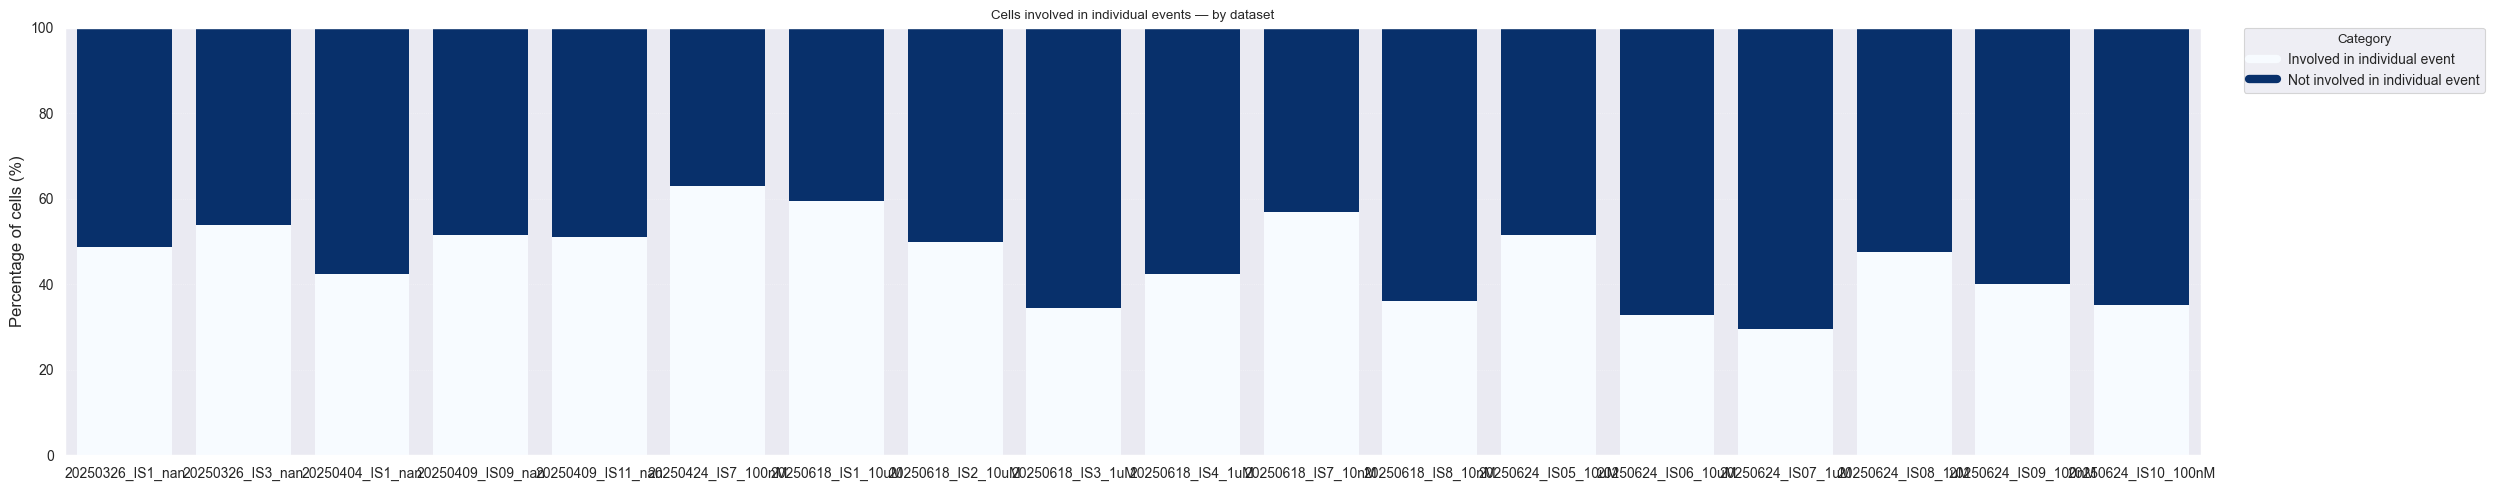

[2025-08-26 14:34:18] [INFO] calcium: plot_violin: removed 339 outliers out of 14047 on 'Duration (s)' (lower=-33, upper=80)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


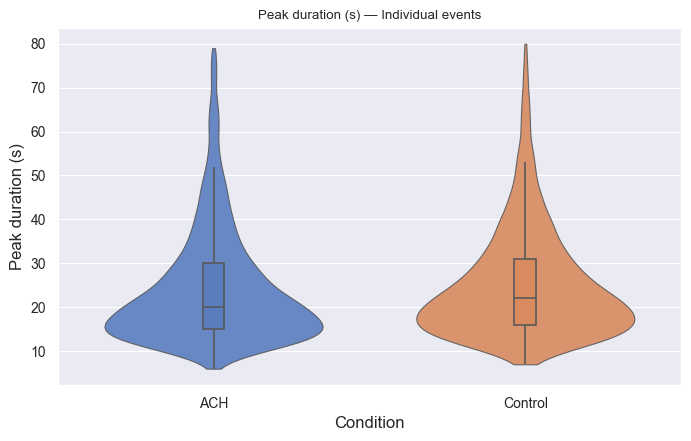

[2025-08-26 14:34:18] [INFO] calcium: plot_violin: removed 339 outliers out of 14047 on 'Duration (s)' (lower=-33, upper=80)
[2025-08-26 14:34:19] [INFO] calcium: plot_violin: removed 605 outliers out of 14047 on 'Prominence (noise std units)' (lower=-50.8, upper=110.9)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1092: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


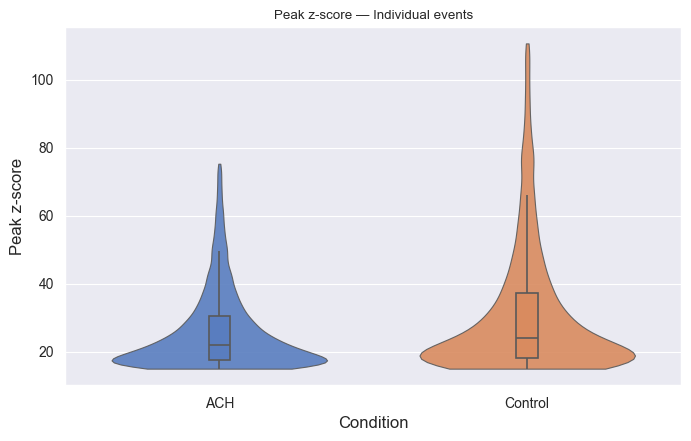

[2025-08-26 14:34:20] [INFO] calcium: plot_violin: removed 605 outliers out of 14047 on 'Prominence (noise std units)' (lower=-50.8, upper=110.9)


In [8]:

# Participation (cells with >0 individual events)
for df in (ach_cells, ctrl_cells):
    df["Involved in individual event"] = np.where(df["Occurrences in individual events"].fillna(0) > 0,
                                                  "Involved in individual event", "Not involved in individual event")

cells_all = pd.concat([ach_cells.assign(condition_group="ACH"),
                       ctrl_cells.assign(condition_group="Control")], ignore_index=True)

plot_category_distribution_by_dataset(
    df=cells_all,
    category_col="Involved in individual event",
    dataset_col="dataset",
    title="Cells involved in individual events — by dataset",
    ylabel="Percentage of cells (%)",
    palette="Blues",
    figsize=(25, 5),
)

# Peak metrics (individual)
indiv_peaks_all = pd.concat([ach_peaks[ach_peaks["In event"]=="individual"].assign(condition_group="ACH"),
                             ctrl_peaks[ctrl_peaks["In event"]=="individual"].assign(condition_group="Control")])
for metric, label in [("Duration (s)", "Peak duration (s)"),
                      ("Prominence (noise std units)", "Peak z-score")]:
    plot_violin(
        df=indiv_peaks_all,
        x="condition_group",
        y=metric,
        title=f"{label} — Individual events",
        xlabel="Condition",
        ylabel=label,
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="condition_group",
        width=0.7, dodge=False
    )
    brunner_pairs(
        df=indiv_peaks_all.assign(group=indiv_peaks_all["condition_group"]),
        group_col="group", value_col=metric,
        filter_outliers=True, outliers_bounds=(3,3), outliers_bygroup="group",
        n_boot_ci=1000, alpha=0.05, print_results=False, p_adjust_method="holm"
    )


## 7) Cell participation cross-relationships

[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: removed 21/14389 outliers on 'Y' (lower=-6, upper=8)
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=8008 for X=0
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=4152 for X=1
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=1506 for X=2
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=497 for X=3
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=142 for X=4
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=44 for X=5
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=12 for X=6
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=3 for X=7
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=3 for X=8
[2025-08-26 14:34:20] [INFO] calcium: plot_points_mean_std: N=1 for X=9


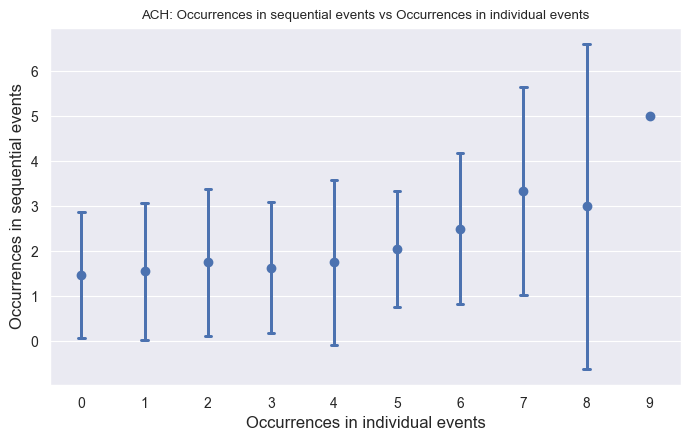

[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: removed 0/14389 outliers on 'Y' (lower=-2, upper=12)
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=3823 for X=0
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=4591 for X=1
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=2935 for X=2
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=1567 for X=3
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=782 for X=4
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=374 for X=5
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=183 for X=6
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=75 for X=7
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=38 for X=8
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=12 for X=9
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=5 for X=10
[2025-08-26 14:34:28] [INFO] calcium: plot_points_mean_std: N=2 for X=11


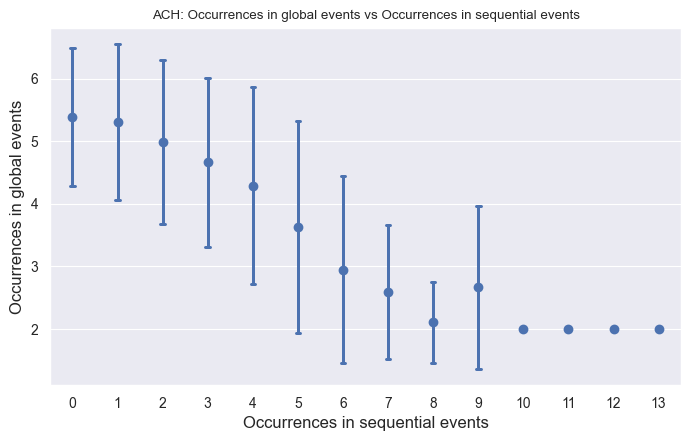

[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: removed 0/14389 outliers on 'Y' (lower=-2, upper=12)
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=8015 for X=0
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=4161 for X=1
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=1510 for X=2
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=497 for X=3
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=143 for X=4
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=44 for X=5
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=12 for X=6
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=3 for X=7
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=3 for X=8
[2025-08-26 14:34:36] [INFO] calcium: plot_points_mean_std: N=1 for X=9


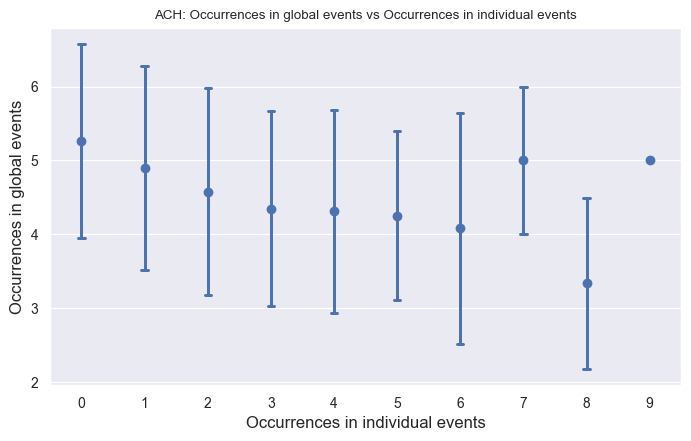

[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: removed 4/5629 outliers on 'Y' (lower=-7, upper=14)
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=2851 for X=0
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=1652 for X=1
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=739 for X=2
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=267 for X=3
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=72 for X=4
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=34 for X=5
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=7 for X=6
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=1 for X=7
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=1 for X=8
[2025-08-26 14:34:43] [INFO] calcium: plot_points_mean_std: N=1 for X=10


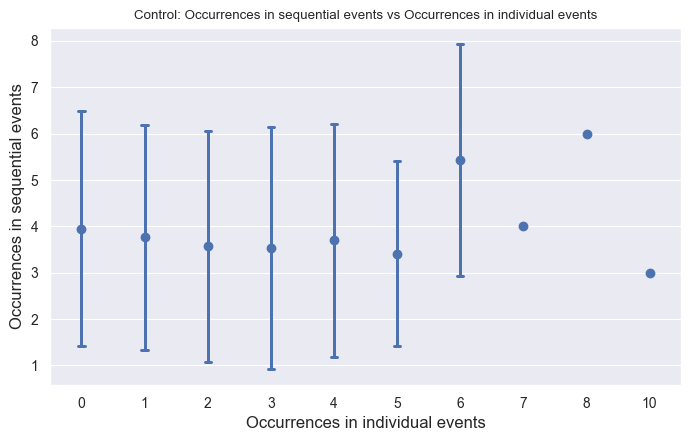

[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: removed 0/5629 outliers on 'Y' (lower=1, upper=8)
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=393 for X=0
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=629 for X=1
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=829 for X=2
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=960 for X=3
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=873 for X=4
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=665 for X=5
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=465 for X=6
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=323 for X=7
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=220 for X=8
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=123 for X=9
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=80 for X=10
[2025-08-26 14:34:45] [INFO] calcium: plot_points_mean_std: N=27 for X=11
[2

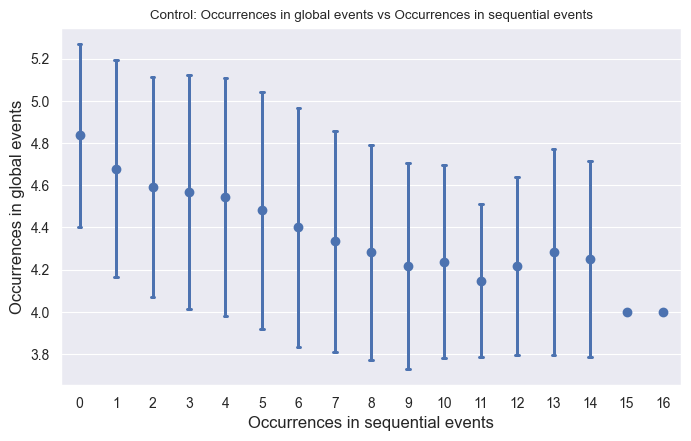

[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: removed 0/5629 outliers on 'Y' (lower=1, upper=8)
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=2854 for X=0
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=1653 for X=1
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=739 for X=2
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=267 for X=3
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=72 for X=4
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=34 for X=5
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=7 for X=6
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=1 for X=7
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=1 for X=8
[2025-08-26 14:34:48] [INFO] calcium: plot_points_mean_std: N=1 for X=10


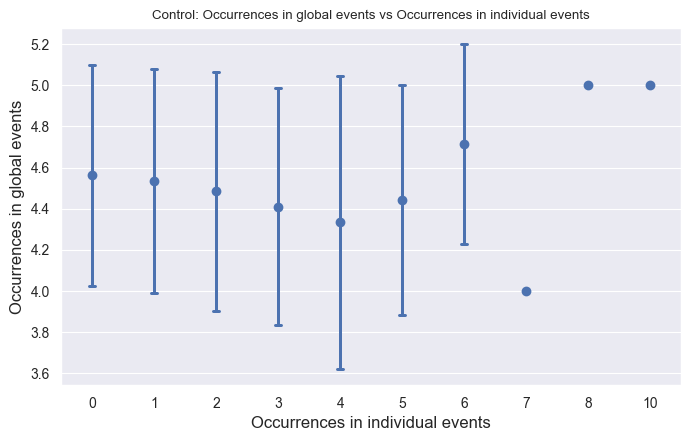

In [9]:

# Compare (individual vs sequential), (sequential vs global), (individual vs global) by condition
def _paired_occurrence_plots(cells_df: pd.DataFrame, condition_name: str):
    ref = cells_df.copy()
    # Some quick scatter/mean±std without heavy filtering (you can tune thresholds if needed)
    for (xcol, ycol) in [
        ("Occurrences in individual events","Occurrences in sequential events"),
        ("Occurrences in sequential events","Occurrences in global events"),
        ("Occurrences in individual events","Occurrences in global events"),
    ]:
        plot_points_mean_std(
            df=ref.rename(columns={xcol:"X", ycol:"Y"}),
            x="X", y="Y",
            title=f"{condition_name}: {ycol} vs {xcol}",
            xlabel=xcol, ylabel=ycol,
            show_points=False,
            filter_outliers=True, outliers_bounds=(3,3),
        )
        # Non-parametric corr
        corr_nonparametric(
            df=ref,
            x_col=xcol, y_col=ycol,
            methods=["spearman","kendall"], alpha=0.05, n_boot_ci=1000
        )

_paired_occurrence_plots(ach_cells, "ACH")
_paired_occurrence_plots(ctrl_cells, "Control")
